In [1]:
from utils import ignore  # noqa: just here to ignore warnings
from collections import defaultdict
from concurrent.futures import ProcessPoolExecutor, as_completed
from datetime import datetime, timedelta

import h5py
import numpy as np
from gwpy.time import from_gps, to_gps
from gwpy.timeseries import TimeSeriesDict, TimeSeries
from gwpy.segments import DataQualityDict, DataQualityFlag, SegmentList
from tqdm import tqdm


# set up some data query hyperparameters up front
IFOS = ["H1", "L1"]
START = "01 April 2019"
NUM_TRAIN_WEEKS = 1
NUM_TEST_WEEKS = 2
MIN_DURATION = 8192

start_date = datetime.strptime(START, "%d %B %Y")
duration = timedelta(weeks=NUM_TRAIN_WEEKS + NUM_TEST_WEEKS)
end_date = start_date + duration

# convert to GPS timestamps
start = to_gps(start_date).gpsSeconds
end = to_gps(end_date).gpsSeconds

# query segments where all interferometers have
# open, analysis-ready data
segments = DataQualityDict()
for ifo in IFOS:
    dqf = f"{ifo}_DATA"
    segments[ifo] = DataQualityFlag.fetch_open_data(dqf, start, end)
segments = segments.intersection().active

# filter out any segments that are too short
# to be worth analyzing
if MIN_DURATION is not None:
    segments = filter(lambda i: i[1] - i[0] >= MIN_DURATION, segments)
    segments = SegmentList(segments)

# summarize our findings for the good people
total_duration = sum([i[1] - i[0] for i in segments])
print(
    "{} active segments between {} and {} "
    "corresponding to {:0.2f} days worth of data".format(
        len(segments),
        start_date.strftime("%d %B %Y"),
        end_date.strftime("%d %B %Y"),
        total_duration / 3600 / 24
    )
)

33 active segments between 01 April 2019 and 22 April 2019 corresponding to 7.06 days worth of data


In [2]:
def is_test(segment):
    dt = timedelta(weeks=NUM_TRAIN_WEEKS)
    return (from_gps(segment[0]) - dt) > start_date


def is_train(segment):
    return not is_test(segment)


train_segments = list(filter(is_train, segments))
test_segments = list(filter(is_test, segments))

valid_frac = 0.2
durations = [i[1] - i[0] for i in train_segments]
durations = np.cumsum(durations)
idx = np.searchsorted(durations, (1 - valid_frac) * durations[-1])
valid_segments = train_segments[idx:]
train_segments = train_segments[:idx]

background_splits = dict(
    train=train_segments,
    valid=valid_segments,
    test=test_segments
)
split_map = {i: k for k, v in background_splits.items() for i in v}

In [3]:
psds = {i: 0 for i in IFOS}
with h5py.File("data/background.hdf5", mode="a") as f:
    for segment in tqdm(segments):
        start, end = segment
        split = split_map[segment]

        try:
            group = f[split]
        except KeyError:
            group = f.create_group(split)
    
        duration = end - start
        name = f"{start}-{duration}"
        try:
            dataset = group[name]
        except KeyError:
            dataset = group.create_group(name)
            dataset.attrs["start"] = start
            dataset.attrs["duration"] = duration

            x = TimeSeriesDict()
            for ifo in IFOS:
                ts = TimeSeries.fetch_open_data(
                    ifo,
                    start=start,
                    end=end,
                    sample_rate=4096
                )
                ts = ts.resample(2048)
                x[ifo] = ts
            x.write(dataset, chunks=(2048 * 128,))
        else:
            if split == "train":
                x = TimeSeriesDict.read(dataset, path=IFOS)

        if split == "train":
            for ifo in IFOS:
                psd = x[ifo].psd(fftlength=2, method="median", window="hann")
                psds[ifo] += psd / len(train_segments)
        f.flush()

100%|█████████████████████████████████████████████████████████████████████| 33/33 [01:35<00:00,  2.89s/it]


In [4]:
import numpy as np
from astropy.cosmology import Planck15
from bilby.core.prior import (
    ConditionalPowerLaw,
    ConditionalPriorDict,
    Constraint,
    Cosine,
    Gaussian,
    PowerLaw,
    PriorDict,
    Sine,
    Uniform
)
from bilby.core.utils.random import seed
from bilby.gw.prior import UniformComovingVolume

def mass_condition(_, mass_1):
    return dict(maximum=mass_1)

msun = r"$M_{\odot}$"
prior = dict(
    redshift=UniformComovingVolume(0, 2, name="redshift", cosmology=Planck15),
    mass1=PowerLaw(alpha=-2.35, minimum=5, maximum=100, unit=msun),
    mass2=ConditionalPowerLaw(
        condition_func=mass_condition,
        alpha=1,
        minimum=5,
        maximum=100,
        unit=msun,
    ),
    spin1_mag=Uniform(0, 0.998),
    spin2_mag=Uniform(0, 0.998),
    spin1_tilt=Sine(unit="rad"),
    spin2_tilt=Sine(unit="rad"),
    spin1_azimuth=Uniform(0, 2 * np.pi),
    spin2_azimuth=Uniform(0, 2 * np.pi),
    inclination=Sine(unit="rad")
)
prior = PriorDict(prior)

Now in the spirit of absolute clarity, I could very explicitly write out the code for the various steps involved in generating a waveform dataset.
1. Sample intrinsic parameters of a source event
2. Simulate the waveform of gravitational strain produced by it
3. Sample sky parameters relative to the geocenter
4. Use these to compute the detector's response to the waveform
5. Measure the SNR of this response with respect to the PSD of the training data
6. If the SNR is over our threshold, keep the waveform. Otherwise, discard it and record a rejection
7. Repeat until the threshold is passed
8. Repeat until you have enough waveforms to fit a big neural network

However, it turns out this process is pretty laborious, and making it run in an amount of time that I would have any intention of sitting around for takes some slightly fancy footwork.
It's nothing too crazy, but I'll resort to building some custom objects which lend themselves to multiprocessing more naturally.

In practice, we normally end up massively parallelizing this over a compute cluster using HTCondor, but doing this with any level of elegance requires quite a bit of extra infra that goes outside the scope of this tutorial.
Alternatively, we could use some of our `ml4gw` tools to accelerate the detector response and SNR calculations and even move them to GPU.
However, that would defeat the secondary purpose of illustrating what this workflow looked like before these tools.
Moreover, the main bottleneck here is on the waveform simulation, so we don't gain too much by accelerating/tensor-fying these other operations.

That said, `pycbc` has `pycuda` bindings which can move the waveform simulation to GPU as well, which seems to speed that up by about a factor of 3.
However, in the realisitic distributed computing case, our clusters tend to have many more CPUs than GPUs available, and so while moving this compute to GPU brings improvements in per-waveform _latency_, it ultimately restricts total _throughput_ by restricting the amount of computing resources you're able to parallelize over.
Of course, this can also be solved by more robust infrastructure that uses both CPUs and GPUs and dynamically picks the appropriate compute backend, but now we're going out-of-scope again.

In [22]:
from pycbc.detector import Detector
from pycbc.filter.matchedfilter import sigmasq, make_frequency_series
from pycbc.types import FrequencySeries, TimeSeries
from pycbc.waveform import get_td_waveform


class WaveformSampler:
    def __init__(
        self,
        prior: PriorDict,
        max_length: float,
        sample_rate: float,
        f_lower: float = 10,
        f_ref: float = 50,
        approximant: str = "IMRPhenomD",
        snr_threshold: float = 0,
        highpass: float = 0,
        **psds: np.ndarray
    ) -> None:
        self.prior = prior
        self.psds = psds
        self.max_size = int(max_length * sample_rate)
        self.delta_t = 1 / sample_rate
        self.f_lower = f_lower
        self.f_ref = f_ref
        self.approximant = approximant

        self.highpass = highpass
        self.snr_threshold = snr_threshold
        self.skyloc_prior = PriorDict(dict(
            declination=Cosine(),
            right_ascension=Uniform(0, 2 * np.pi),
            polarization=Uniform(0, np.pi)
        ))

    def convert_to_detector_frame(self, **params):
        converted = {}
        for k, v in params.items():
            if k.startswith("mass"):
                converted[k] = v * (1 + params["redshift"])
            else:
                converted[k] = v
        return converted

    def generate_waveform(self, **params):
        params = self.convert_to_detector_frame(**params)
        hp, hc = get_td_waveform(
            **params,
            delta_t=self.delta_t,
            f_lower=self.f_lower,
            f_ref=self.f_ref,
            approximant=self.approximant
        )

        # IMRPhenomD includes a bunch of extra time
        # after the ringdown that we don't want
        mask = hp.sample_times.data < 0.05
        hp, hc = hp[mask], hc[mask]
        hp, hc =  hp[-self.max_size:], hc[-self.max_size:]

        # pycbc waveforms are scaled up by a factor of
        # 1 / delta_t for some reason I can't understand
        hp *= self.delta_t
        hc *= self.delta_t

        # convert back to timeseries to take advantage
        # of nice things like built-in fft methods
        hp = TimeSeries(hp, delta_t=self.delta_t)
        hc = TimeSeries(hc, delta_t=self.delta_t)
        return hp, hc

    def sample_params(self):
        params = self.prior.sample()
        spherical = ["mag", "tilt", "azimuth"]
        for i in range(2):
            mag, tilt, azi = [params.pop(f"spin{i+1}_{j}") for j in spherical]
            params[f"spin{i+1}_x"] = mag * np.sin(tilt) * np.cos(azi)
            params[f"spin{i+1}_y"] = mag * np.sin(tilt) * np.sin(azi)
            params[f"spin{i+1}_z"] = mag * np.cos(tilt)
        return params

    def compute_ht(self, ifo, hc, hp, t_gps, skyloc):
        detector = Detector(ifo)
        fp, fc = detector.antenna_pattern(t_gps=t_gps, **skyloc)
        return fp * hp + fc * hc

    def compute_snr(self, ifo, ht):
        htilde = make_frequency_series(ht)
        psd = self.psds[ifo].interpolate(htilde.delta_f)
        psd = FrequencySeries(psd.value, delta_f=htilde.delta_f)
        return sigmasq(htilde, psd, low_frequency_cutoff=self.highpass)

    def __call__(self, t_gps):
        num_rejected = 0
        while True:
            params = self.sample_params()
            hp, hc = self.generate_waveform(**params)
            skyloc = self.skyloc_prior.sample()
            if self.snr_threshold == 0 or not self.psds:
                break

            snr = 0
            for ifo, psd in self.psds.items():
                ht = self.compute_ht(ifo, hc, hp, t_gps, skyloc)
                snr += self.compute_snr(ifo, ht)
            snr **= 0.5
            if snr >= self.snr_threshold:
                break
            num_rejected += 1

        params |= skyloc
        params["snr"] = snr
        return hp, hc, params, num_rejected

In [14]:
sampler = WaveformSampler(
    prior,
    max_length=4,
    sample_rate=2048,
    f_lower=10,
    f_ref=50,
    approximant="IMRPhenomD",
    snr_threshold=4,
    highpass=32,
    **psds
)

In [20]:
import os

# need to seed bilby's random number generator in 
# each worker process otherwise they'll all generate
# the same samples. Lessons you learn the hard way...
def initializer():
    seed(os.getpid())

split_sizes = dict(train=50000, valid=10000)
t_gps = to_gps(start_date).gpsSeconds

f = h5py.File("data/signals.hdf5", "w")
ex = ProcessPoolExecutor(16, initializer=initializer)
try:
    # allocate memory for polarization datasets up front
    # while our waveforms begin to generate
    futures = {}
    for split, size in split_sizes.items():
        fs = [ex.submit(sampler, t_gps=t_gps) for _ in range(size)]
        fs = enumerate(fs)
        futures.update({future: (i, split) for i, future in fs})

        group = f.create_group(split)
        group.attrs["num_rejected"] = 0

        polars = group.create_group("polarizations")
        params = group.create_group("parameters")

        print(f"Initializing datasets for {split} split")
        polars.create_dataset("cross", shape=(size, sampler.max_size))
        polars.create_dataset("plus", shape=(size, sampler.max_size))
        print("Waveform datasets initialized")

    # write them to disk as they come in
    fs = list(futures.keys())
    for future in tqdm(as_completed(fs), total=len(fs)):
        idx, split = futures.pop(future)
        hp, hc, p, n_rej = future.result()

        group = f[split]
        group["polarizations"]["plus"][idx, -len(hp):] = hp
        group["polarizations"]["cross"][idx, -len(hc):] = hc

        params = group["parameters"]
        for k, v in p.items():
            try:
                dset = params[k]
            except KeyError:
                size = split_sizes[split]
                dset = params.create_dataset(k, shape=(size,))
            dset[idx] = v
        group.attrs["num_rejected"] += n_rej
        if not (idx + 1) % 1000:
            f.flush()
except Exception:
    ex.shutdown(wait=False, cancel_futures=True)
    raise
finally:
    f.close()

Initializing datasets for train split
Waveform datasets initialized
Initializing datasets for valid split
Waveform datasets initialized


100%|███████████████████████████████████████████████████████████████████| 240/240 [00:19<00:00, 12.61it/s]


In [6]:
from math import ceil

test_background_time_weeks = 2
seconds_per_week = 3600 * 24 * 7
test_background_time_seconds = test_background_time_weeks * seconds_per_week

test_segments = background_splits["test"]
test_background_livetime = sum([i[1] - i[0] for i in test_segments])

num_shifts = ceil(test_background_time_seconds / test_background_livetime)
shifts_per_ifo = ceil(num_shifts / 2)

In [23]:
from scipy.signal import windows


class TestWaveformSampler(WaveformSampler):
    def __init__(self, *args, taper_length=0.5, **kwargs):
        super().__init__(*args, **kwargs)
        taper_size = int(taper_length / self.delta_t)
        taper = windows.hann(2 * taper_size)
        self.taper = taper[:taper_size]

    """
    This time, a call to the sampler will generate
    all the waveforms for a
    """
    def __call__(self, t_gps: float):
        num_rejected = 0
        while True:
            params = self.sample_params()
            hp, hc = self.generate_waveform(**params)
            skyloc = self.skyloc_prior.sample()

            hts, snr = {}, 0
            for ifo, psd in self.psds.items():
                ht = self.compute_ht(ifo, hc, hp, t_gps, skyloc)
                ht[:len(self.taper)] *= self.taper
                hts[ifo] = ht
                if self.snr_threshold > 0:
                    snr += self.compute_snr(ifo, ht)
            snr **= 0.5
            if snr >= self.snr_threshold:
                break
            num_rejected += 1

        params |= skyloc
        params["snr"] = snr

        # compute the probability of this sample
        # under _just_ the mass components of
        # the prior, this way we can use importance
        # sampling to reweight to other mass priors
        # after we run inference
        masses = {f"mass{i+1}": params[f"mass{i+1}"] for i in range(2)}
        params["prob"] = self.prior.prob(masses)
        return hts, params, num_rejected

In [24]:
sampler = TestWaveformSampler(
    prior,
    max_length=4,
    sample_rate=2048,
    f_lower=10,
    f_ref=50,
    approximant="IMRPhenomD",
    snr_threshold=4,
    highpass=32,
    **psds
)

In [25]:
from tqdm import trange

rejects = []
t_gps = to_gps(start_date).gpsSeconds
for i in trange(100):
    *_, num_rejected = sampler(t_gps)
    rejects.append(num_rejected)

  0%|                                                                             | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_2609764/3697181178.py:43: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  params["prob"] = self.prior.prob(masses)
100%|███████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.40it/s]


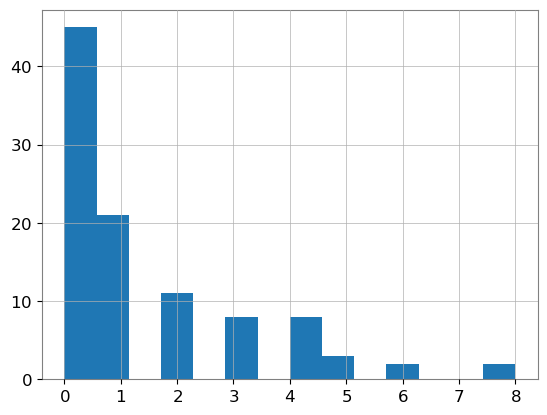

In [26]:
import matplotlib.pyplot as plt
_ = plt.hist(rejects, bins=14)

In [ ]:
spacing = 16
f = h5py.File("data/signals.hdf5", "a")
ex = ProcessPoolExecutor(16, initializer=initializer)
try:
    try:
        split = f["test"]
    except KeyError:
        split = f.create_group("test")

    futures = {}
    for start, stop in background_splits["test"]:
        duration = stop - start
        key = f"{start}-{duration}"
        try:
            segment = split[key]
        except KeyError:
            segment = split.create_group(key)

        for shift in range(1, shifts_per_ifo + 1):
            end = stop - shift
            for j in range(2):
                if len(futures) == num_shifts:
                    break
                shift_key = [0, shift] if not j else [shift, 0]
                shift_key = str(shift_key)
                try:
                    group = segment[shift_key]
                except KeyError:
                    group = segment.create_group(shift_key)

                num_signals = int((end - start) // spacing) - 1
                timestamps = np.arange(num_signals)
                timestamps = start + spacing / 2 + timestamps * spacing
                shape = (len(timestamps), sampler.max_size)

                for ifo in IFOS:
                    group.create_dataset(ifo, shape=shape)

                group.attrs["num_rejected"] = 0
                params = group.create_group("parameters")
                params["gps_time"] = timestamps

                for i, t_gps in enumerate(timestamps):
                    future = ex.submit(sampler, t_gps)
                    futures[future] = (key, shift_key, i)

    # write them to disk as they come in
    fs = list(futures.keys())
    for future in tqdm(as_completed(fs), total=len(fs)):
        key, shift, idx = futures.pop(future)
        waveforms, p, num_rejected = future.result()

        dataset = split[key][shift]
        for ifo in IFOS:
            dataset[ifo][idx] = waveforms[ifo]
        dataset.attrs["num_rejected"] += num_rejected

        params = dataset["parameters"]
        size = len(params["gps_time"])
        for k, v in p.items():
            try:
                dset = params[k]
            except KeyError:
                dset = params.create_dataset(k, shape=(size,))
            dset[idx] = v

        if (idx + 1) == size:
            f.flush()
except Exception:
    ex.shutdown(wait=False, cancel_futures=True)
    raise
else:
    ex.shutdown(wait=True, cancel_futures=False)
finally:
    f.close()

/tmp/ipykernel_2281439/3697181178.py:43: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  params["prob"] = self.prior.prob(masses)
/tmp/ipykernel_2281439/3697181178.py:43: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  params["prob"] = self.prior.prob(masses)
/tmp/ipykernel_2281439/3697181178.py:43: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  params["prob"] = self.prior.prob(masses)
/tmp/ipykernel_2281439/3697181178.py:43: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  params["prob"] = self.prior.prob(masses)
/tmp/ipykernel_2281439/3697181178.py:43: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead